## Import Libraries

In [ ]:
import pandas as pd
import os

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer


from sklearn.svm import LinearSVC

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LogisticRegression

from sklearn.naive_bayes import GaussianNB

from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier

from sklearn.svm import SVC

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

from imblearn.over_sampling import SMOTENC
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

def csv(predicciones,nombre,df_test):
    y_pred = pd.DataFrame({'id':df_test['id'],'Predicted':predicciones})
    y_pred['Predicted'] = y_pred['Predicted'].astype(int)
    y_pred.to_csv(nombre,index=False)

def standard_scale(df):
    '''Devuelve un dataframe con las columnas escaladas'''
    scaler = StandardScaler()
    string = df.select_dtypes(include=['object']).columns #solo vamos a escalar las columnas que no son string
    df_no_string = df.drop(string,axis=1)
    df_no_string = scaler.fit_transform(df_no_string)
    df_no_string = pd.DataFrame(df_no_string,columns=df.drop(string,axis=1).columns)
    df_escaled = df.copy()
    df_escaled[df_no_string.columns] = df_no_string
    return df_escaled





## Load Data

In [2375]:
directorio = '../apau-smog-prediction/'
lista = os.listdir(directorio)
for i in lista:
    exec(i.split('.')[0] + ' = pd.read_csv(directorio + i)')

Eliminamos todas las columnas que hemos explicado en el apartado de preparación de datos.

In [2376]:
smog = train['Smog']
train = train.drop(['id','Comb (L/100 km)','Comb (mpg)','Model','Model Year','Smog'], axis=1)
id =test_nolabel['id']
test_nolabel = test_nolabel.drop(['id','Comb (L/100 km)','Comb (mpg)','Model','Model Year'], axis=1)

In [2377]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 586 entries, 0 to 585
Data columns (total 9 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Make                              586 non-null    object 
 1   Vehicle Class                     586 non-null    object 
 2   Engine Size (L)                   586 non-null    float64
 3   Cylinders                         586 non-null    int64  
 4   Transmission                      586 non-null    object 
 5   Fuel Type                         586 non-null    object 
 6   Fuel Consumption City (L/100 km)  586 non-null    float64
 7   Hwy (L/100 km)                    586 non-null    float64
 8   CO2 Emissions (g/km)              586 non-null    int64  
dtypes: float64(3), int64(2), object(4)
memory usage: 41.3+ KB


Vamos a resolver el problema de desbalanceo de clases con la técnica de oversampling de SMOTENC con diferentes estrategias de sampling: mayority
y not majority.

In [2378]:
sm = SMOTENC(random_state=42, categorical_features=[0,1,4,5], sampling_strategy='minority', k_neighbors=5)
sm_auto = SMOTENC(random_state=42, categorical_features=[0,1,4,5], sampling_strategy='auto', k_neighbors=5)
train_mayority, smog_mayority = sm.fit_resample(train, smog)
train_auto, smog_auto = sm_auto.fit_resample(train, smog)



### Train, train_mayority y train_auto

Text(0.5, 1.0, 'Smog auto')

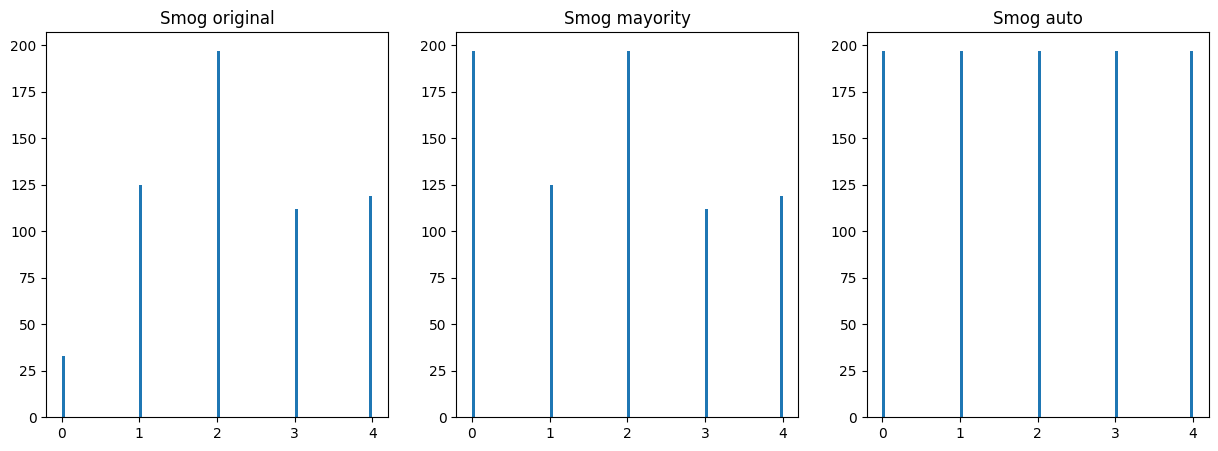

In [2379]:
ax,fig = plt.subplots(1,3,figsize=(15,5))

fig[0].hist(smog, bins=100)
fig[0].set_title('Smog original')

fig[1].hist(smog_mayority, bins=100)
fig[1].set_title('Smog mayority')

fig[2].hist(smog_auto, bins=100)
fig[2].set_title('Smog auto')


### Pipeline

Pipeline nos sirve para encadenar varios pasos en un mismo objeto. En este caso, vamos a encadenar el preprocesado de los datos y el entrenamiento del modelo.

In [2380]:
cat_cols = train.select_dtypes(include="object").columns.tolist()
num_cols = train.select_dtypes(exclude="object").columns.tolist()

cat_pipe = Pipeline([
    ("ohe", OneHotEncoder(handle_unknown="ignore"))
])

num_pipe = Pipeline([
    ("scaler", StandardScaler())
])


preprocessor = ColumnTransformer([
    ("cat", cat_pipe, cat_cols),#aplicamos onehotencoder a las columnas categóricas
    ("num", num_pipe, num_cols)#aplicamos standard scaler a las columnas numéricas
])

In [2381]:
lista_entreno = [train,train_mayority,train_auto]
lista_smog = [smog,smog_mayority,smog_auto]
lista_nombres = ['original','mayority','auto']

#### Árboles de decisión

##### Random Forest Classifier

In [2382]:
rf = Pipeline([
    ("pre", preprocessor),
    ("rf", RandomForestClassifier(random_state=42,class_weight='balanced'))
])



In [2383]:

from sklearn.model_selection import cross_validate
for i in np.arange(0,3):
    scores = cross_validate(rf, lista_entreno[i], lista_smog[i], cv=5, scoring=['accuracy','f1_macro'])
    print('Accuracy: ', scores['test_accuracy'].mean())
    print('F1: ', scores['test_f1_macro'])
    print('F1_mean: ', scores['test_f1_macro'].mean())
    print('train:',lista_nombres[i])
    print('-'*50)



Accuracy:  0.8054469071418223
F1:  [0.83353374 0.84384208 0.83249153 0.87247811 0.75548732]
F1_mean:  0.8275665554665693
train: original
--------------------------------------------------
Accuracy:  0.8346666666666668
F1:  [0.80777125 0.85567245 0.85191127 0.8397077  0.77452148]
F1_mean:  0.8259168301364491
train: mayority
--------------------------------------------------
Accuracy:  0.8670050761421321
F1:  [0.81385255 0.85324192 0.83980167 0.94243232 0.88057746]
F1_mean:  0.8659811836208459
train: auto
--------------------------------------------------


In [2384]:
extra_trees = Pipeline([
    ("pre", preprocessor),
    ("rf", ExtraTreesClassifier(random_state=42,class_weight='balanced'))
])

In [2385]:
for i in np.arange(0,3):
    scores = cross_validate(extra_trees, lista_entreno[i], lista_smog[i], cv=5, scoring=['accuracy','f1_macro'])
    print('Accuracy: ', scores['test_accuracy'].mean())
    print('F1: ', scores['test_f1_macro'])
    print('F1_mean: ', scores['test_f1_macro'].mean())
    print('train:',lista_nombres[i])
    print('-'*50)

Accuracy:  0.8070983630305666
F1:  [0.85802722 0.82432323 0.81824018 0.85965794 0.76976557]
F1_mean:  0.826002828303141
train: original
--------------------------------------------------
Accuracy:  0.8346666666666666
F1:  [0.8135092  0.84691426 0.84221276 0.86237683 0.75404057]
F1_mean:  0.8238107246595844
train: mayority
--------------------------------------------------
Accuracy:  0.8619289340101524
F1:  [0.80557958 0.8379849  0.85793696 0.9383839  0.86415972]
F1_mean:  0.8608090133681608
train: auto
--------------------------------------------------


In [2386]:
gd = Pipeline([
    ("pre", preprocessor),
    ("gd", GradientBoostingClassifier(random_state=42))
])


In [2353]:
for i in np.arange(0,3):
    scores = cross_validate(gd, lista_entreno[i], lista_smog[i], cv=5, scoring=['accuracy','f1_macro'])
    print('Accuracy: ', scores['test_accuracy'].mean())
    print('F1: ', scores['test_f1_macro'])
    print('F1_mean: ', scores['test_f1_macro'].mean())
    print('train:',lista_nombres[i])
    print('-'*50)

Accuracy:  0.7832536578299291
F1:  [0.79327592 0.84292929 0.78695509 0.84675439 0.76114653]
F1_mean:  0.8062122437414532
train: original
--------------------------------------------------
Accuracy:  0.8160000000000001
F1:  [0.79769038 0.84427128 0.78754518 0.86038367 0.74390699]
F1_mean:  0.8067594993259494
train: mayority
--------------------------------------------------
Accuracy:  0.8324873096446701
F1:  [0.7575627  0.85260044 0.81017926 0.9129731  0.82822709]
F1_mean:  0.8323085168956925
train: auto
--------------------------------------------------


#### Algoritmo geométrico

In [2349]:
svc = Pipeline([
    ("pre", preprocessor),
    ("svc", SVC(random_state=42,class_weight='balanced'))
])

In [2354]:
for i in np.arange(0,3):
    scores = cross_validate(svc, lista_entreno[i], lista_smog[i], cv=5, scoring=['accuracy','f1_macro'])
    print('Accuracy: ', scores['test_accuracy'].mean())
    print('F1: ', scores['test_f1_macro'])
    print('F1_mean: ', scores['test_f1_macro'].mean())
    print('train:',lista_nombres[i])
    print('-'*50)

Accuracy:  0.7320295523685354
F1:  [0.80492647 0.78454282 0.76628533 0.78812121 0.69028908]
F1_mean:  0.7668329818914901
train: original
--------------------------------------------------
Accuracy:  0.7933333333333333
F1:  [0.75384667 0.78419657 0.79534362 0.82026836 0.76547076]
F1_mean:  0.7838251929096675
train: mayority
--------------------------------------------------
Accuracy:  0.8243654822335026
F1:  [0.76434643 0.82101127 0.81440927 0.87280504 0.84389207]
F1_mean:  0.8232928138986353
train: auto
--------------------------------------------------


##### Gaussian Naive Bayes

Hemos encontrado problemas a la hora de entrenar con Gaussian Naive Bayes:
-  A sparse matrix was passed, but dense data is required. Use X.toarray() to convert to a dense numpy array.
No hemos sabido emplear Pipeline para resolver este problema, por lo que el preprocesado será manual.
-  Para Gaussian Naive Bayes, las variables deben seguir una distribución gaussiana

In [2361]:
train_scale = standard_scale(train)
train_dummies = pd.get_dummies(train_scale)


train_mayority_scale =standard_scale(train_mayority)
train_mayority_dummies = pd.get_dummies(train_mayority_scale)

train_auto_scale = standard_scale(train_auto)
train_auto_dummies = pd.get_dummies(train_auto_scale)

In [2363]:
gnb = GaussianNB()

In [2364]:
lista_entreno_1 = [train_dummies,train_mayority_dummies,train_auto_dummies]

In [2365]:
for i in np.arange(0,3):
    scores = cross_validate(gnb, lista_entreno_1[i], lista_smog[i], cv=5, scoring=['accuracy','f1_macro'])
    print('Accuracy: ', scores['test_accuracy'].mean())
    print('F1: ', scores['test_f1_macro'])
    print('F1_mean: ', scores['test_f1_macro'].mean())
    print('train:',lista_nombres[i])
    print('-'*50)

Accuracy:  0.5204838476024916
F1:  [0.50749236 0.54385803 0.50811263 0.53020068 0.58234134]
F1_mean:  0.5344010078642193
train: original
--------------------------------------------------
Accuracy:  0.6173333333333333
F1:  [0.54789329 0.60270012 0.53974542 0.58474613 0.60246329]
F1_mean:  0.5755096508059493
train: mayority
--------------------------------------------------
Accuracy:  0.6761421319796954
F1:  [0.57324754 0.60798348 0.64912238 0.73028172 0.66566655]
F1_mean:  0.645260336391304
train: auto
--------------------------------------------------


### Stacking

Stacking es una técnica de ensamblaje de modelos que consiste en entrenar varios modelos y combinar sus predicciones para obtener una predicción final.
En este caso vamos a combinar los modelos rf, extra_trees y svc con un modelo de regresión logística.

In [2371]:
estimators = [
    ('rf',rf),
    ('extra_trees',extra_trees),
    ('svc',svc),
]

stacking = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(solver='saga',class_weight='balanced',max_iter=1000))

# con lbfgs falla al converger

In [2372]:
stacking.fit(lista_entreno[0],lista_smog[0])

StackingClassifier(estimators=[('rf',
                                Pipeline(steps=[('pre',
                                                 ColumnTransformer(transformers=[('cat',
                                                                                  Pipeline(steps=[('ohe',
                                                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                                                  ['Make',
                                                                                   'Vehicle '
                                                                                   'Class',
                                                                                   'Transmission',
                                                                                   'Fuel '
                                                                                   'Type']),
                                                                                 ('num',
                                                                                  Pipeline(steps=[('scaler',
                                                                                                   StandardScaler())]),
                                                                                  ['Engine '
                                                                                   'Size '
                                                                                   '(L)',
                                                                                   'Cylinders',
                                                                                   'Fuel '
                                                                                   'Consumption '
                                                                                   'City '
                                                                                   '(L/100 '
                                                                                   'km)',
                                                                                   'Hwy '
                                                                                   '...
                                                                                   'Class',
                                                                                   'Transmission',
                                                                                   'Fuel '
                                                                                   'Type']),
                                                                                 ('num',
                                                                                  Pipeline(steps=[('scaler',
                                                                                                   StandardScaler())]),
                                                                                  ['Engine '
                                                                                   'Size '
                                                                                   '(L)',
                                                                                   'Cylinders',
                                                                                   'Fuel '
                                                                                   'Consumption '
                                                                                   'City '
                                                                                   '(L/100 '
                                                                                   'km)',
                                                                                   'Hwy '
                                                                

In [2373]:
scores = cross_validate(stacking, lista_entreno[0], lista_smog[0], cv=5, scoring=['accuracy','f1_macro'])
scores

{'fit_time': array([4.00143647, 4.31947184, 5.5003736 , 4.64689612, 5.69449997]),
 'score_time': array([0.0295651 , 0.08453131, 0.04824948, 0.06256533, 0.03424239]),
 'test_accuracy': array([0.8220339 , 0.78632479, 0.82905983, 0.84615385, 0.72649573]),
 'test_f1_macro': array([0.83386871, 0.82286967, 0.85433154, 0.86386869, 0.75480836])}

In [2387]:
stacking.fit(lista_entreno[1],lista_smog[1])

StackingClassifier(estimators=[('rf',
                                Pipeline(steps=[('pre',
                                                 ColumnTransformer(transformers=[('cat',
                                                                                  Pipeline(steps=[('ohe',
                                                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                                                  ['Make',
                                                                                   'Vehicle '
                                                                                   'Class',
                                                                                   'Transmission',
                                                                                   'Fuel '
                                                                                   'Type']),
                                                                                 ('num',
                                                                                  Pipeline(steps=[('scaler',
                                                                                                   StandardScaler())]),
                                                                                  ['Engine '
                                                                                   'Size '
                                                                                   '(L)',
                                                                                   'Cylinders',
                                                                                   'Fuel '
                                                                                   'Consumption '
                                                                                   'City '
                                                                                   '(L/100 '
                                                                                   'km)',
                                                                                   'Hwy '
                                                                                   '...
                                                                                   'Class',
                                                                                   'Transmission',
                                                                                   'Fuel '
                                                                                   'Type']),
                                                                                 ('num',
                                                                                  Pipeline(steps=[('scaler',
                                                                                                   StandardScaler())]),
                                                                                  ['Engine '
                                                                                   'Size '
                                                                                   '(L)',
                                                                                   'Cylinders',
                                                                                   'Fuel '
                                                                                   'Consumption '
                                                                                   'City '
                                                                                   '(L/100 '
                                                                                   'km)',
                                                                                   'Hwy '
                                                                

In [ ]:
scores = cross_validate(stacking, lista_entreno[1], lista_smog[1], cv=5, scoring=['accuracy','f1_macro'])
scores

{'fit_time': array([4.32774234, 4.50204825, 4.79816079, 4.61881518, 4.67699194]),
 'score_time': array([0.03163195, 0.0373888 , 0.03887367, 0.03580928, 0.04759908]),
 'test_accuracy': array([0.82      , 0.84666667, 0.86      , 0.88666667, 0.78666667]),
 'test_f1_macro': array([0.81925125, 0.83531134, 0.84795796, 0.87808783, 0.77604868])}

In [ ]:
stacking.fit(lista_entreno[2],lista_smog[2])

In [ ]:
scores = cross_validate(stacking, lista_entreno[2], lista_smog[2], cv=5, scoring=['accuracy','f1_macro'])
scores